In [1]:
# 0) 只需跑一次
!pip install -q yfinance pandas


In [2]:
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import yfinance as yf

DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)

def _to_taipei(idx):
    idx = pd.to_datetime(idx, utc=True, errors="coerce")
    if idx.tz is None: idx = idx.tz_localize("UTC")
    return idx.tz_convert("Asia/Taipei")

def _flatten_columns(df):
    # MultiIndex 的順序是 (Price, Ticker) → 取第 0 層（Price）
    if isinstance(df.columns, pd.MultiIndex):
        df = df.copy()
        df.columns = df.columns.get_level_values(0)
    return df


def get_prices(tickers, start="2020-01-01", end=None, force_from_start=False, auto_adjust=False):
    if isinstance(tickers, str): tickers=[tickers]
    if end is None: end = datetime.now().strftime("%Y-%m-%d")
    out={}
    for t in tickers:
        fp = DATA_DIR / f"{t}.csv"

        def _dl(s,e):
            df = yf.download(t, start=s, end=e, auto_adjust=auto_adjust, group_by="column", progress=False)
            if not df.empty:
                df = _flatten_columns(df)
                df.index = _to_taipei(df.index)
            return df

        if force_from_start or not fp.exists():
            df = _dl(start,end)
            if not df.empty: df.to_csv(fp, date_format="%Y-%m-%d")
            out[t]=df; continue

        df = pd.read_csv(fp, index_col=0, parse_dates=[0]); df.index=_to_taipei(df.index)
        first_utc, last_utc = df.index.min().tz_convert("UTC"), df.index.max().tz_convert("UTC")

        if pd.to_datetime(start) < first_utc.tz_localize(None):
            pre = _dl(start, first_utc.strftime("%Y-%m-%d"))
            if not pre.empty: df = pd.concat([pre, df])

        next_start = (last_utc + timedelta(days=1)).strftime("%Y-%m-%d")
        if next_start < end:
            post = _dl(next_start, end)
            if not post.empty: df = pd.concat([df, post])

        df = df[~df.index.duplicated(keep="last")].sort_index()
        if not df.empty: df.to_csv(fp, date_format="%Y-%m-%d")
        out[t]=df
    return out

def build_market_frames(data, tickers=None, price_col="Adj Close", vol_col="Volume"):
    if tickers is None: tickers = list(data.keys())
    p_parts, v_parts = [], []
    for t in tickers:
        df = data.get(t, pd.DataFrame())
        if df.empty: continue
        if price_col in df.columns and not df[price_col].isna().all():
            p_parts.append(df[[price_col]].rename(columns={price_col:t}))
        if vol_col in df.columns and not df[vol_col].isna().all():
            v_parts.append(df[[vol_col]].rename(columns={vol_col:t}))
    prices  = pd.concat(p_parts, axis=1).sort_index() if p_parts else pd.DataFrame()
    volumes = pd.concat(v_parts, axis=1).sort_index() if v_parts else pd.DataFrame()
    prices  = prices.dropna(how="all"); volumes = volumes.dropna(how="all")
    returns = prices.pct_change().dropna(how="all")
    return prices, volumes, returns


In [3]:
import yfinance as yf
d = yf.download("AAPL", start="2020-01-01", auto_adjust=False, group_by="column", progress=False)
print(type(d.columns), d.columns)  # MultiIndex
d = _flatten_columns(d)
print(d.columns)                   # Index(['Open','High','Low','Close','Adj Close','Volume'], dtype='object')


<class 'pandas.core.indexes.multi.MultiIndex'> MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [4]:
stocks = ["2330.TW","AAPL","NVDA","MSFT","SOXX","QQQ","SPY","DX-Y.NYB","^VIX"]

# 重抓（不一定要 force，但第一次建議 True）
data   = get_prices(stocks, start="2020-01-01", force_from_start=True, auto_adjust=False)
prices, volumes, returns = build_market_frames(data, tickers=stocks, price_col="Adj Close")

print("起訖：", prices.index.min(), "→", prices.index.max())
print("標的：", list(prices.columns))
print(prices.head())


起訖： 2020-01-02 08:00:00+08:00 → 2025-08-18 08:00:00+08:00
標的： ['2330.TW', 'AAPL', 'NVDA', 'MSFT', 'SOXX', 'QQQ', 'SPY', 'DX-Y.NYB', '^VIX']
Price                         2330.TW       AAPL      NVDA        MSFT  \
Date                                                                     
2020-01-02 08:00:00+08:00  302.557312  72.538528  5.971746  153.042297   
2020-01-03 08:00:00+08:00  303.003571  71.833282  5.876163  151.136658   
2020-01-06 08:00:00+08:00  296.309875  72.405670  5.900806  151.527359   
2020-01-07 08:00:00+08:00  294.078583  72.065147  5.972244  150.145737   
2020-01-08 08:00:00+08:00  294.078583  73.224419  5.983446  152.537354   

Price                           SOXX         QQQ         SPY   DX-Y.NYB   ^VIX  
Date                                                                            
2020-01-02 08:00:00+08:00  81.308838  209.091080  299.406525  96.849998  12.47  
2020-01-03 08:00:00+08:00  79.792358  207.175812  297.139252  96.839996  14.02  
2020-01-06 08:00:

C:\Users\USER\AppData\Local\Temp\ipykernel_5952\1459918481.py:70: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")


In [5]:
print(volumes.head())

Price                         2330.TW         AAPL         NVDA        MSFT  \
Date                                                                          
2020-01-02 08:00:00+08:00  31754120.0  135480400.0  237536000.0  22622100.0   
2020-01-03 08:00:00+08:00  41811268.0  146322800.0  205384000.0  21116200.0   
2020-01-06 08:00:00+08:00  45343057.0  118387200.0  262636000.0  20813700.0   
2020-01-07 08:00:00+08:00  50879181.0  108872000.0  314856000.0  21634100.0   
2020-01-08 08:00:00+08:00  37567748.0  132079200.0  277108000.0  27746500.0   

Price                           SOXX         QQQ         SPY  DX-Y.NYB  ^VIX  
Date                                                                          
2020-01-02 08:00:00+08:00  1275300.0  30969400.0  59151200.0       0.0   0.0  
2020-01-03 08:00:00+08:00  1235100.0  27518900.0  77709700.0       0.0   0.0  
2020-01-06 08:00:00+08:00  1615200.0  21655300.0  55653900.0       0.0   0.0  
2020-01-07 08:00:00+08:00  1146600.0  22139300.0  4

In [6]:
print(returns.head())

Price                       2330.TW      AAPL      NVDA      MSFT      SOXX  \
Date                                                                          
2020-01-03 08:00:00+08:00  0.001475 -0.009722 -0.016006 -0.012452 -0.018651   
2020-01-06 08:00:00+08:00 -0.022091  0.007968  0.004194  0.002585 -0.010417   
2020-01-07 08:00:00+08:00 -0.007530 -0.004703  0.012106 -0.009118  0.018402   
2020-01-08 08:00:00+08:00  0.000000  0.016086  0.001876  0.015929 -0.000907   
2020-01-09 08:00:00+08:00  0.024279  0.021241  0.010983  0.012493  0.006318   

Price                           QQQ       SPY  DX-Y.NYB      ^VIX  
Date                                                               
2020-01-03 08:00:00+08:00 -0.009160 -0.007573 -0.000103  0.124298  
2020-01-06 08:00:00+08:00  0.006443  0.003815 -0.001755 -0.012126  
2020-01-07 08:00:00+08:00 -0.000139 -0.002812  0.003207 -0.004332  
2020-01-08 08:00:00+08:00  0.007516  0.005330  0.003300 -0.024656  
2020-01-09 08:00:00+08:00  0.008474  0

In [7]:
prices.isna().sum()

Price
2330.TW     97
AAPL        48
NVDA        48
MSFT        48
SOXX        48
QQQ         48
SPY         48
DX-Y.NYB    46
^VIX        48
dtype: int64

In [8]:
prices_clean=prices.ffill().bfill()

In [9]:
prices_clean.isna().sum()

Price
2330.TW     0
AAPL        0
NVDA        0
MSFT        0
SOXX        0
QQQ         0
SPY         0
DX-Y.NYB    0
^VIX        0
dtype: int64

In [10]:
volumes.isna().sum()

Price
2330.TW     97
AAPL        48
NVDA        48
MSFT        48
SOXX        48
QQQ         48
SPY         48
DX-Y.NYB    46
^VIX        48
dtype: int64

In [11]:
#對齊
volumes_clean = volumes.reindex(columns=prices_clean.columns)


volumes_clean = volumes.reindex(index=prices_clean.index)


In [12]:
volumes_clean = volumes_clean.apply(pd.to_numeric, errors="coerce")  # 防止字串混入
volumes_clean = volumes_clean.fillna(0)                              # 休市 / 缺值 → 設為 0


In [13]:
volumes_clean.isna().sum()

Price
2330.TW     0
AAPL        0
NVDA        0
MSFT        0
SOXX        0
QQQ         0
SPY         0
DX-Y.NYB    0
^VIX        0
dtype: int64

In [14]:
returns_simple = prices_clean.pct_change()

In [15]:
returns_simple.head()

Price,2330.TW,AAPL,NVDA,MSFT,SOXX,QQQ,SPY,DX-Y.NYB,^VIX
Date,,,,,,,,,
2020-01-02 08:00:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 08:00:00+08:00,0.001475,-0.009722,-0.016006,-0.012452,-0.018651,-0.009160,-0.007573,-0.000103,0.124298
2020-01-06 08:00:00+08:00,-0.022091,0.007968,0.004194,0.002585,-0.010417,0.006443,0.003815,-0.001755,-0.012126
2020-01-07 08:00:00+08:00,-0.007530,-0.004703,0.012106,-0.009118,0.018402,-0.000139,-0.002812,0.003207,-0.004332
2020-01-08 08:00:00+08:00,0.000000,0.016086,0.001876,0.015929,-0.000907,0.007516,0.005330,0.003300,-0.024656


In [16]:
returns_simple = returns_simple.dropna(how="all")

In [17]:
returns_simple.isna().sum()

Price
2330.TW     0
AAPL        0
NVDA        0
MSFT        0
SOXX        0
QQQ         0
SPY         0
DX-Y.NYB    0
^VIX        0
dtype: int64

In [18]:
print(prices_clean.index.equals(volumes_clean))
print(prices_clean.index.equals(returns_simple))

False
False


In [19]:
print("volumes_clean 缺的日期：", prices_clean.index.difference(volumes_clean.index))
print("returns_simple 缺的日期：", prices_clean.index.difference(returns_simple.index))


volumes_clean 缺的日期： DatetimeIndex([], dtype='datetime64[ns, Asia/Taipei]', name='Date', freq=None)
returns_simple 缺的日期： DatetimeIndex(['2020-01-02 08:00:00+08:00'], dtype='datetime64[ns, Asia/Taipei]', name='Date', freq=None)


In [20]:
print("volumes_clean 多的日期：", volumes_clean.index.difference(prices_clean.index))
print("returns_simple 多的日期：", returns_simple.index.difference(prices_clean.index))


volumes_clean 多的日期： DatetimeIndex([], dtype='datetime64[ns, Asia/Taipei]', name='Date', freq=None)
returns_simple 多的日期： DatetimeIndex([], dtype='datetime64[ns, Asia/Taipei]', name='Date', freq=None)


In [21]:
# 取得三者的共同日期
common_index = prices_clean.index.intersection(volumes_clean.index).intersection(returns_simple.index)

# 對齊
prices_clean = prices_clean.loc[common_index]
volumes_clean = volumes_clean.loc[common_index]
returns_simple = returns_simple.loc[common_index]

# 驗證
print(prices_clean.index.equals(volumes_clean.index))
print(prices_clean.index.equals(returns_simple.index)) 


True
True


In [22]:
print(prices.columns.equals(volumes.columns))  
print(prices.columns.equals(returns.columns))  


True
True


In [23]:
print(prices_clean.isna().sum().sum())   
print(volumes_clean.isna().sum().sum())  
print(returns_simple.isna().sum().sum())  


0
0
0


In [24]:
weights=[0.3000, 0.1299, 0.3000, 0.1701, 0.0500, 0.0500]  #一開始是等權，算完最佳權重後改為最佳權重(限制版)

portfolio_daily_return=returns_simple[['2330.TW','AAPL','NVDA','MSFT','QQQ','SPY']].mul(weights).sum(axis=1)

In [25]:
portfolio_value = (1 + portfolio_daily_return).cumprod() * 100

In [26]:
portfolio_cum_return = portfolio_value / 100 - 1


In [27]:
print(portfolio_cum_return)

Date
2020-01-03 08:00:00+08:00   -0.008577
2020-01-06 08:00:00+08:00   -0.011929
2020-01-07 08:00:00+08:00   -0.012855
2020-01-08 08:00:00+08:00   -0.006928
2020-01-09 08:00:00+08:00    0.009185
                               ...   
2025-08-12 08:00:00+08:00    7.056397
2025-08-13 08:00:00+08:00    7.072571
2025-08-14 08:00:00+08:00    7.030116
2025-08-15 08:00:00+08:00    7.005511
2025-08-18 08:00:00+08:00    7.014847
Length: 1461, dtype: float64


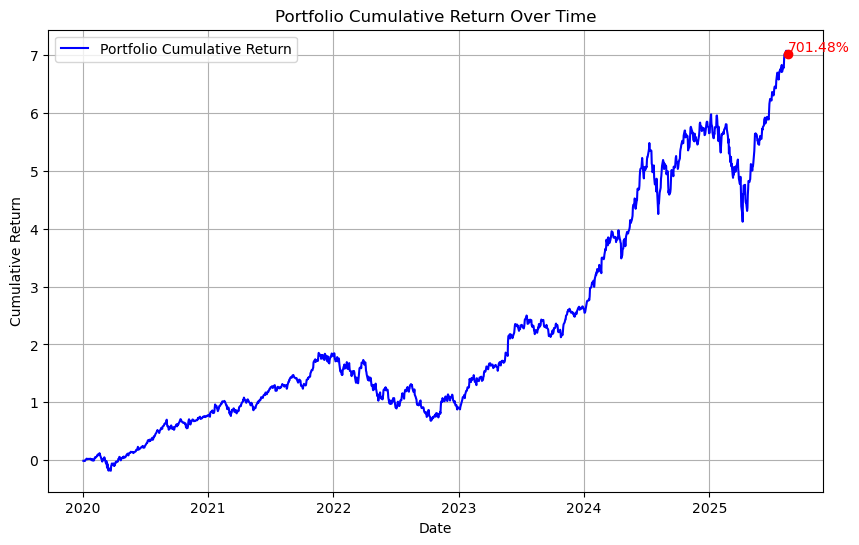

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(portfolio_cum_return, label='Portfolio Cumulative Return', color='blue')

# 高亮今天的值
today = portfolio_cum_return.index[-1]
today_value = portfolio_cum_return.iloc[-1]
plt.scatter(today, today_value, color='red', zorder=5)
plt.text(today, today_value, f"{today_value:.2%}", 
         fontsize=10, color='red', ha='left', va='bottom')

plt.title("Portfolio Cumulative Return Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# 計算 SPY 的累積報酬率
spy_cum_return = (1 + returns_simple['SPY']).cumprod()


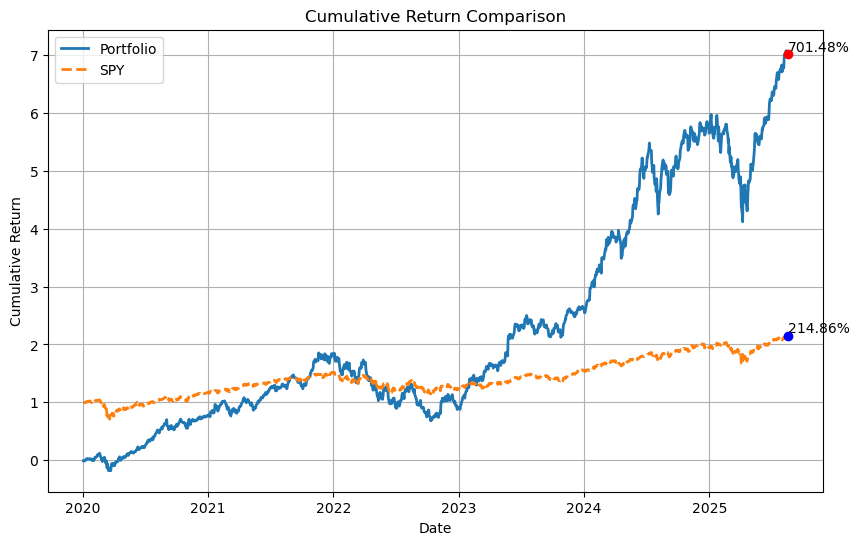

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(portfolio_cum_return, label='Portfolio', linewidth=2)
plt.plot(spy_cum_return, label='SPY', linewidth=2, linestyle='--')

# 取得今天的日期與數值
today_date = portfolio_cum_return.index[-1]
today_value = portfolio_cum_return.iloc[-1]

# 標示投資組合今天的值
plt.scatter(today_date, today_value, color='red', zorder=5)
plt.text(today_date, today_value, f'{today_value:.2%}', fontsize=10, ha='left', va='bottom')

# 標示 SPY 今天的值
spy_today_value = spy_cum_return.iloc[-1]
plt.scatter(today_date, spy_today_value, color='blue', zorder=5)
plt.text(today_date, spy_today_value, f'{spy_today_value:.2%}', fontsize=10, ha='left', va='bottom')

plt.title('Cumulative Return Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import numpy as np

portfolio_cum_return_w=(1+returns_simple[['2330.TW','AAPL','NVDA','MSFT','QQQ','SPY']]).cumprod()

portfolio_nav = portfolio_cum_return_w.mul(weights, axis=1).sum(axis=1)
portfolio_nav = portfolio_nav / portfolio_nav.iloc[0]
portfolio_ret=portfolio_nav.pct_change().fillna(0.0)

# 投資組合 CAGR
n_days = len(portfolio_nav)
cagr_port = (portfolio_nav.iloc[-1] / portfolio_nav.iloc[0])**(252/n_days) - 1


spy_cagr = (1 + float(spy_cum_return.iloc[-1]))**(252 / spy_cum_return.shape[0]) - 1



In [32]:
print(cagr_port)
print(spy_cagr)

0.5272363979132582
0.21875724086488302


In [33]:
vol_port=portfolio_ret.std(ddof=1) * np.sqrt(252)
spy_vol=returns_simple['SPY'].std()*(252**0.5)

In [34]:
print(vol_port)
print(spy_vol)

0.3557353592423327
0.20876843858606722


In [35]:
rf = 0.043  # 無風險利率約 4.3%
sharpe_adjusted_port = (cagr_port - rf) / vol_port
sharpe_adjusted_spy = (spy_cagr-rf)/spy_vol

In [36]:
print(sharpe_adjusted_port)
print(sharpe_adjusted_spy)

1.3612264997907855
0.8418764927076133


In [37]:
# 用資產價值曲線計算
portfolio_value_2 = (1 + portfolio_daily_return).cumprod()

max_drawdown = (portfolio_value_2 / portfolio_value_2.cummax() - 1).min()

print(f"最大回撤: {max_drawdown:.2%}")


最大回撤: -41.09%


In [38]:
#"2330.TW","AAPL","NVDA","MSFT","SOXX","QQQ","SPY"
#單檔累積報酬率
TSMC_cum_return = (1 + returns_simple['2330.TW']).cumprod()
AAPL_cum_return = (1 + returns_simple['AAPL']).cumprod()
NVDA_cum_return = (1 + returns_simple['NVDA']).cumprod()
MSFT_cum_return = (1 + returns_simple['MSFT']).cumprod()
SOXX_cum_return = (1 + returns_simple['SOXX']).cumprod()
QQQ_cum_return = (1 + returns_simple['QQQ']).cumprod()

In [39]:
#單檔年化報酬率
TSMC_cagr = (1 + float(TSMC_cum_return.iloc[-1]))**(252 / TSMC_cum_return.shape[0]) - 1
AAPL_cagr = (1 + float(AAPL_cum_return.iloc[-1]))**(252 / AAPL_cum_return.shape[0]) - 1
NVDA_cagr = (1 + float(NVDA_cum_return.iloc[-1]))**(252 / NVDA_cum_return.shape[0]) - 1
MSFT_cagr = (1 + float(MSFT_cum_return.iloc[-1]))**(252 / MSFT_cum_return.shape[0]) - 1
SOXX_cagr = (1 + float(SOXX_cum_return.iloc[-1]))**(252 / SOXX_cum_return.shape[0]) - 1
QQQ_cagr = (1 + float(QQQ_cum_return.iloc[-1]))**(252 / QQQ_cum_return.shape[0]) - 1

In [40]:
#單檔年化波動
TSMC_vol=returns_simple['2330.TW'].std()*(252**0.5)
AAPL_vol=returns_simple['AAPL'].std()*(252**0.5)
NVDA_vol=returns_simple['NVDA'].std()*(252**0.5)
MSFT_vol=returns_simple['MSFT'].std()*(252**0.5)
SOXX_vol=returns_simple['SOXX'].std()*(252**0.5)
QQQ_vol=returns_simple['QQQ'].std()*(252**0.5)

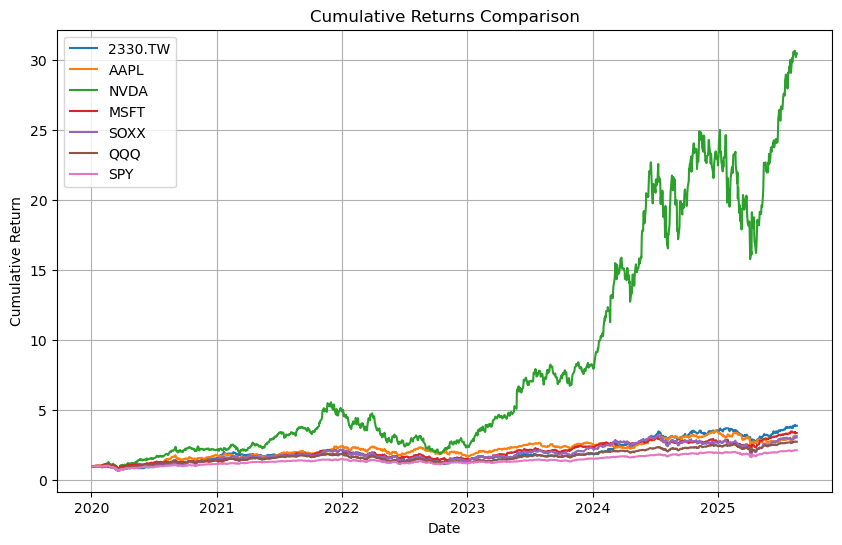

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(TSMC_cum_return, label='2330.TW')
plt.plot(AAPL_cum_return, label='AAPL')
plt.plot(NVDA_cum_return, label='NVDA')
plt.plot(MSFT_cum_return, label='MSFT')
plt.plot(SOXX_cum_return, label='SOXX')
plt.plot(QQQ_cum_return, label='QQQ')
plt.plot(spy_cum_return, label='SPY')

plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


     Stock  Cumulative Return       CAGR  Volatility
0  2330.TW         390.008753  31.537485   28.872682
1     AAPL         318.299812  27.996193   31.900732
2     NVDA        3047.852018  81.294404   53.292891
3     MSFT         337.880432  29.010172   29.674001
4     SOXX         306.301270  27.355274   37.250770
5      QQQ         276.008898  25.664561   25.393769
6      SPY         214.858373  21.875724   20.876844


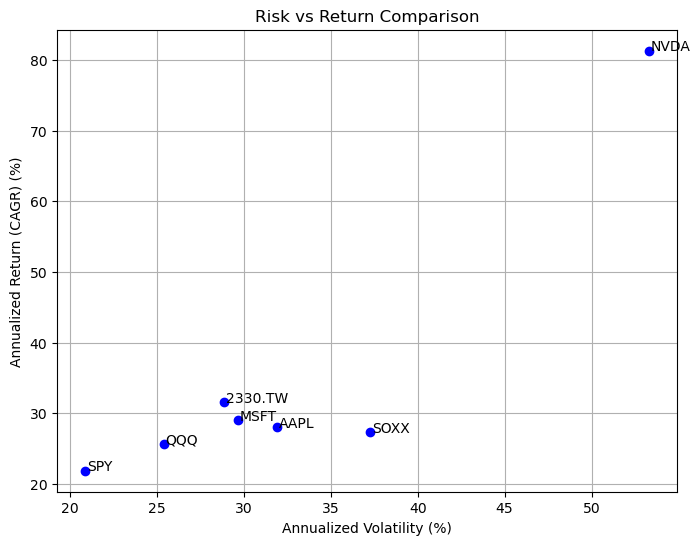

In [42]:
KPI_Single = {
    'Stock': ['2330.TW', 'AAPL', 'NVDA', 'MSFT', 'SOXX', 'QQQ', 'SPY'],
    'Cumulative Return': [
        TSMC_cum_return.iloc[-1], AAPL_cum_return.iloc[-1], NVDA_cum_return.iloc[-1],
        MSFT_cum_return.iloc[-1], SOXX_cum_return.iloc[-1], QQQ_cum_return.iloc[-1],
        spy_cum_return.iloc[-1]
    ],
    'CAGR': [
        TSMC_cagr, AAPL_cagr, NVDA_cagr, MSFT_cagr, SOXX_cagr, QQQ_cagr, spy_cagr
    ],
    'Volatility': [
        TSMC_vol, AAPL_vol, NVDA_vol, MSFT_vol, SOXX_vol, QQQ_vol, spy_vol
    ]
}

KPI_Single_table = pd.DataFrame(KPI_Single)

# 轉換成百分比顯示（表格內）
KPI_Single_table['Cumulative Return'] = KPI_Single_table['Cumulative Return'] * 100
KPI_Single_table['CAGR'] = KPI_Single_table['CAGR'] * 100
KPI_Single_table['Volatility'] = KPI_Single_table['Volatility'] * 100

print(KPI_Single_table)

# ====== 2. 風險 vs 報酬散點圖 ======
plt.figure(figsize=(8, 6))
plt.scatter(KPI_Single_table['Volatility'], KPI_Single_table['CAGR'], c='blue')

# 標註股票代碼
for i in range(len(KPI_Single_table)):
    plt.text(KPI_Single_table['Volatility'][i] + 0.1, KPI_Single_table['CAGR'][i], KPI_Single_table['Stock'][i])

plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Annualized Return (CAGR) (%)')
plt.title('Risk vs Return Comparison')
plt.grid(True)
plt.show()

In [43]:
# 無風險利率
rf = 0.043  # 4.3%

# 計算 Sharpe Ratio
KPI_Single_table['Sharpe Ratio'] = (KPI_Single_table['CAGR'] / 100 - rf) / (KPI_Single_table['Volatility'] / 100)

print(KPI_Single_table)


     Stock  Cumulative Return       CAGR  Volatility  Sharpe Ratio
0  2330.TW         390.008753  31.537485   28.872682      0.943365
1     AAPL         318.299812  27.996193   31.900732      0.742810
2     NVDA        3047.852018  81.294404   53.292891      1.444741
3     MSFT         337.880432  29.010172   29.674001      0.832721
4     SOXX         306.301270  27.355274   37.250770      0.618921
5      QQQ         276.008898  25.664561   25.393769      0.841331
6      SPY         214.858373  21.875724   20.876844      0.841876


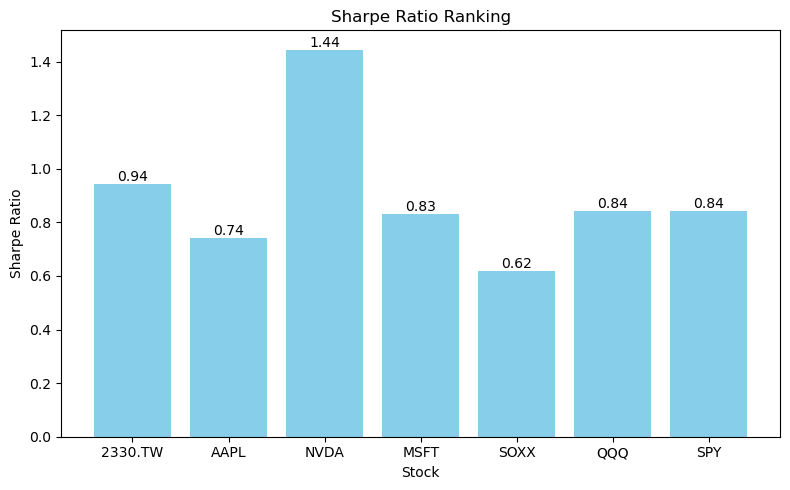

In [44]:
plt.figure(figsize=(8, 5))
bars = plt.bar(KPI_Single_table['Stock'], KPI_Single_table['Sharpe Ratio'], color='skyblue')

# 在條形圖上顯示數值
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f"{bar.get_height():.2f}", ha='center', va='bottom')

plt.title('Sharpe Ratio Ranking')
plt.xlabel('Stock')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.show()

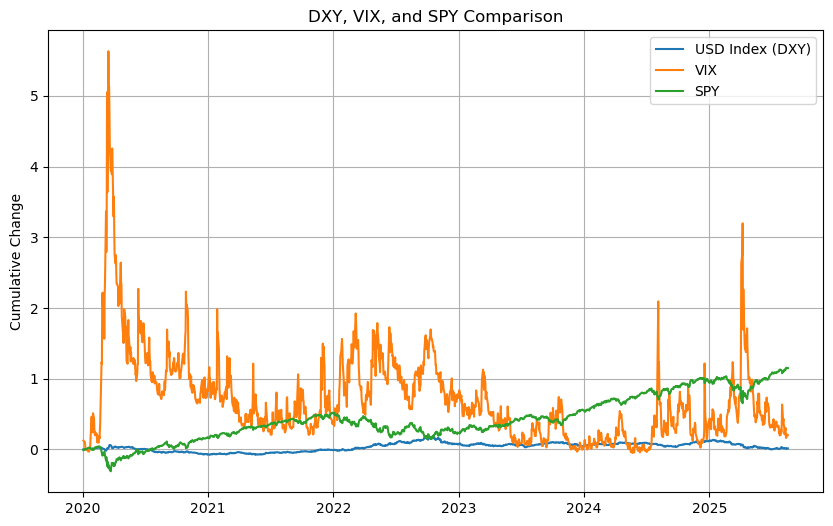

In [45]:
dxy_returns = returns_simple['DX-Y.NYB']
vix_returns = returns_simple['^VIX']

dxy_cum_change = (1 + dxy_returns).cumprod() - 1
vix_cum_change = (1 + vix_returns).cumprod() - 1

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(dxy_cum_change, label='USD Index (DXY)')
plt.plot(vix_cum_change, label='VIX')
plt.plot(spy_cum_return - 1, label='SPY')  # 注意這裡 SPY 是累積報酬率
plt.legend()
plt.title('DXY, VIX, and SPY Comparison')
plt.ylabel('Cumulative Change')
plt.grid(True)
plt.show()


In [46]:
corr_df = pd.DataFrame({
    'DXY': dxy_returns,
    'VIX': vix_returns,
    'SPY': returns_simple['SPY']
})
print(corr_df.corr())


          DXY       VIX       SPY
DXY  1.000000  0.098638 -0.167196
VIX  0.098638  1.000000 -0.716757
SPY -0.167196 -0.716757  1.000000


In [47]:
import os
import pandas as pd

# === 0) 輸出資料夾 ===
OUTDIR = "bi_export"
os.makedirs(OUTDIR, exist_ok=True)

# === 1) 單檔 KPI 表（寬表） ===
# 現在是百分比（×100），保留即可，Power BI 端用格式設定成 % 顯示
kpi_single = KPI_Single_table.copy()
kpi_single.to_csv(f"{OUTDIR}/kpi_single.csv", index=False)

# === 2) 組合＆SPY 累積報酬曲線（長表，便於做多序列折線圖） ===
# 兩者目前是「倍數」，為了在 BI 端顯示%曲線，轉成百分比（減1再×100）
curve_df = pd.concat([
    portfolio_cum_return.rename("Portfolio"),
    spy_cum_return.rename("SPY")
], axis=1)

curve_long = (
    curve_df.reset_index()
    .melt(id_vars=curve_df.reset_index().columns[0], var_name="Series", value_name="CumulativeMultiple")
)
date_col = curve_long.columns[0]  # 一般是 'Date'
curve_long["CumulativeReturnPct"] = (curve_long["CumulativeMultiple"] - 1) * 100
curve_long.rename(columns={date_col: "Date"}, inplace=True)
curve_long[["Date", "Series", "CumulativeReturnPct"]].to_csv(f"{OUTDIR}/cum_curve_long.csv", index=False)

# === 3) 組合 KPI 單值（卡片用，長表） ===
records = [
    {"Metric": "Cumulative Return (%)", "Value": (portfolio_cum_return.iloc[-1]-1)*100},
    {"Metric": "CAGR (%)",               "Value": cagr_port*100},
    {"Metric": "Volatility (%)",         "Value": vol_port*100},
    {"Metric": "Max Drawdown (%)",       "Value": max_drawdown*100},
]
# 如有 Sharpe：
try:
    records.append({"Metric": "Sharpe Ratio", "Value": sharpe_port})
except NameError:
    pass

kpi_port = pd.DataFrame(records)
kpi_port.to_csv(f"{OUTDIR}/kpi_portfolio_cards.csv", index=False)

# === 4) （可選）DXY / VIX 走勢供背景圖用 ===
try:
    dxy_cum = (1 + returns_simple['DX-Y.NYB']).cumprod() - 1
    vix_cum = (1 + returns_simple['^VIX']).cumprod() - 1
    bg = pd.concat([
        dxy_cum.rename("DXY_CumReturn"),
        vix_cum.rename("VIX_CumReturn")
    ], axis=1).reset_index()
    bg.rename(columns={bg.columns[0]: "Date"}, inplace=True)
    # 也轉成百分比
    for col in ["DXY_CumReturn", "VIX_CumReturn"]:
        bg[col] = bg[col] * 100
    bg.to_csv(f"{OUTDIR}/market_background.csv", index=False)
except Exception as e:
    print("Skip market_background export:", e)

# === 5) 更新時間（給 BI 顯示資料最新日期） ===
last_date = pd.to_datetime(curve_df.index.max()).date()
pd.DataFrame([{"LastUpdateDate": last_date}]).to_csv(f"{OUTDIR}/last_update.csv", index=False)

print("✅ Exported CSVs to:", OUTDIR)


✅ Exported CSVs to: bi_export


In [48]:
import numpy as np
import pandas as pd

#轉成日報酬
R = prices_clean.drop(columns=["DX-Y.NYB","^VIX"]).pct_change().dropna()


#計算年化報酬與年化協方差
mu= R.mean()*252
Sigma=R.cov() * 252

#轉np.array
mu=mu.values
Sigma=Sigma.values
n=len(mu)

In [49]:
from math import sqrt

rf=0.043

def portfolio_return(w,mu):
    return float (w @ mu)

def portfolio_var(w,Sigma):
    return float(w @ Sigma @ w)

def portfolio_vol(w,Sigma):
    return sqrt(portfolio_var(w,Sigma))

def neg_sharpe(w,mu,Sigma,rf):
    vol=portfolio_vol(w,Sigma)
    if vol == 0 :
        return np.inf
    return -(portfolio_return(w,mu)-rf)/vol

#最小變異數
def port_var(w,Sigma):
    return float(w @ Sigma @ w)


#權重和=1
cons = (
    {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},
)

#界線
bounds = [(0.0, 1.0)] * n
w0 = np.ones(n) / n  # 初始猜測：等權


In [50]:
from scipy.optimize import minimize

np.set_printoptions(formatter={'float': '{:0.4f}'.format})

# ① 最大夏普
res_max_sharpe = minimize(
    fun=neg_sharpe,
    x0=w0,
    args=(mu, Sigma, rf),
    method="SLSQP",
    bounds=bounds,
    constraints=cons,
    options={"maxiter": 1000, "ftol": 1e-12}
)
w_max_sharpe = res_max_sharpe.x

# ② 最小變異數
res_min_var = minimize(
    fun=port_var,
    x0=w0,
    args=(Sigma,),
    method="SLSQP",
    bounds=bounds,
    constraints=cons,
    options={"maxiter": 1000, "ftol": 1e-12}
)
w_min_var = res_min_var.x


In [51]:
def summarize(w, mu, Sigma, rf=0.0):
    pret = portfolio_return(w, mu)
    pvol = portfolio_vol(w, Sigma)
    sharpe = (pret - rf) / pvol if pvol > 0 else np.nan
    return {"Ann.Return": pret, "Ann.Vol": pvol, "Sharpe": sharpe, "weights": w}

print("Max Sharpe:", summarize(w_max_sharpe, mu, Sigma, rf))
print("Min Variance:", summarize(w_min_var, mu, Sigma, rf))


Max Sharpe: {'Ann.Return': 0.5041465029062762, 'Ann.Vol': 0.31662194953150496, 'Sharpe': 1.4564577837658426, 'weights': array([0.5024, 0.0000, 0.4976, 0.0000, 0.0000, 0.0000, 0.0000])}
Min Variance: {'Ann.Return': 0.19458449711075276, 'Ann.Vol': 0.17761928176156827, 'Sharpe': 0.8534236576535427, 'weights': array([0.3253, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6747])}


In [52]:
R_new=prices_clean.drop(columns=["SOXX","DX-Y.NYB","^VIX"]).pct_change().dropna()

mu_new= R_new.mean()*252
Sigma_new=R_new.cov() * 252

#轉np.array
mu_new=mu_new.values
Sigma_new=Sigma_new.values
n=len(mu_new)

In [53]:
# ===== 範圍限制：每檔 0.05 ~ 0.3 =====
bounds_new = tuple((0.05, 0.3) for _ in range(n))
w0 = np.ones(n) / n  # 初始猜測：等權

In [54]:
from scipy.optimize import minimize

np.set_printoptions(formatter={'float': '{:0.4f}'.format})

# ① 最大夏普
res_max_sharpe_new = minimize(
    fun=neg_sharpe,
    x0=w0,
    args=(mu_new, Sigma_new, rf),
    method="SLSQP",
    bounds=bounds_new,
    constraints=cons,
    options={"maxiter": 1000, "ftol": 1e-12}
)
w_max_sharpe_new = res_max_sharpe_new.x

# ② 最小變異數
res_min_var_new = minimize(
    fun=port_var,
    x0=w0,
    args=(Sigma_new,),
    method="SLSQP",
    bounds=bounds_new,
    constraints=cons,
    options={"maxiter": 1000, "ftol": 1e-12}
)
w_min_var_new = res_min_var_new.x

In [55]:
print("Max Sharpe:", summarize(w_max_sharpe_new, mu_new, Sigma_new, rf))
print('Min Variance',summarize(w_min_var_new,mu_new,Sigma_new,rf))

Max Sharpe: {'Ann.Return': 0.39775728159064316, 'Ann.Vol': 0.2712607141447902, 'Sharpe': 1.307809288599326, 'weights': array([0.3000, 0.1309, 0.3000, 0.1691, 0.0500, 0.0500])}
Min Variance {'Ann.Return': 0.24388613288173394, 'Ann.Vol': 0.2004939519922042, 'Sharpe': 1.0019560734158455, 'weights': array([0.3000, 0.0500, 0.0500, 0.0500, 0.2500, 0.3000])}


In [56]:
import numpy as np
import pandas as pd

def portfolio_bh(R: pd.DataFrame, w, columns=None):
    
    # 保險：只用指定欄，且把權重對齊欄位順序
    if columns is not None:
        R = R[columns]
    w = pd.Series(np.asarray(w, float), index=R.columns).reindex(R.columns).values

    # 1) 各資產「淨值曲線」
    wealth = (1 + R).cumprod()

    # 2) 以「初始權重」加權求組合淨值
    pf_nav = wealth.mul(w, axis=1).sum(axis=1)
    pf_nav = pf_nav / pf_nav.iloc[0]              # 正規化讓第一天=1
    pf_nav.name = "pf_nav"

    # 3) 由淨值推回日報酬
    pf_ret = pf_nav.pct_change().fillna(0.0)
    pf_ret.name = "pf_ret"
    return pf_ret, pf_nav


In [57]:
w_eq  = np.ones(len(R.columns)) / len(R.columns)
w_ms  = pd.Series(w_max_sharpe, index=R.columns).values   # 最大夏普
w_mv  = pd.Series(w_min_var,    index=R.columns).values   # 最小變異數

In [58]:
ret_eq, nav_eq = portfolio_bh(R, w_eq, columns=R.columns)
ret_ms, nav_ms = portfolio_bh(R, w_ms, columns=R.columns)
ret_mv, nav_mv = portfolio_bh(R, w_mv, columns=R.columns)

# 方便後續比較
nav_df = pd.concat(
    [nav_eq.rename("Equal"), nav_ms.rename("MaxSharpe"), nav_mv.rename("MinVar")],
    axis=1
)
ret_df = pd.concat(
    [ret_eq.rename("Equal"), ret_ms.rename("MaxSharpe"), ret_mv.rename("MinVar")],
    axis=1
)


In [59]:
# 年化報酬 & 波動 & 夏普
rf = 0.043
ann_mu  = ret_df.mean() * 252
ann_vol = ret_df.std(ddof=1) * np.sqrt(252)
sharpe  = (ann_mu - rf) / ann_vol

summary = pd.DataFrame({
    "Ann.Return": ann_mu,
    "Ann.Vol": ann_vol,
    "Sharpe": sharpe
})
print(summary.round(4))


           Ann.Return  Ann.Vol  Sharpe
Equal          0.3895   0.3200  1.0826
MaxSharpe      0.5746   0.4008  1.3262
MinVar         0.1908   0.1830  0.8078


In [60]:
Rp=R @ w_max_sharpe
nav = (1 + Rp).cumprod()
rolling_max = nav.cummax()
drawdown = (rolling_max - nav) / rolling_max
max_drawdown = drawdown.max()


In [61]:
import numpy as np

var_95 = np.percentile(Rp, 5)
cvar_95 = Rp[Rp < var_95].mean()


In [62]:
print("Max Drawdown:\n", max_drawdown)
print('\nvar_95:\n',var_95)
print('\ncvar_95:\n',cvar_95)

Max Drawdown:
 0.4976147848001062

var_95:
 -0.02893925218250823

cvar_95:
 -0.04190174312728803


In [63]:
w_eq_new  = np.ones(len(R_new.columns)) / len(R_new.columns)
w_ms_new  = pd.Series(w_max_sharpe_new, index=R_new.columns).values   # 最大夏普
w_mv_new  = pd.Series(w_min_var_new,    index=R_new.columns).values   # 最小變異數

In [64]:
ret_eq_new, nav_eq_new = portfolio_bh(R_new, w_eq_new, columns=R_new.columns)
ret_ms_new, nav_ms_new = portfolio_bh(R_new, w_ms_new, columns=R_new.columns)
ret_mv_new, nav_mv_new = portfolio_bh(R_new, w_mv_new, columns=R_new.columns)

# 方便後續比較
nav_new_df = pd.concat(
    [nav_eq_new.rename("Equal"), nav_ms_new.rename("MaxSharpe"), nav_mv_new.rename("MinVar")],
    axis=1
)
ret_new_df = pd.concat(
    [ret_eq_new.rename("Equal"), ret_ms_new.rename("MaxSharpe"), ret_mv_new.rename("MinVar")],
    axis=1
)


In [65]:
rf = 0.043
ann_mu_new  = ret_new_df.mean() * 252
ann_vol_new = ret_new_df.std(ddof=1) * np.sqrt(252)
sharpe_new  = (ann_mu_new - rf) / ann_vol_new

summary_new = pd.DataFrame({
    "Ann.Return": ann_mu_new,
    "Ann.Vol": ann_vol_new,
    "Sharpe": sharpe_new
})
print(summary_new.round(4))

           Ann.Return  Ann.Vol  Sharpe
Equal          0.4039   0.3179  1.1353
MaxSharpe      0.4891   0.3569  1.2498
MinVar         0.2824   0.2287  1.0466


In [66]:
Rp_new=R_new @ w_max_sharpe_new
nav_new = (1 + Rp_new).cumprod()
rolling_max_new = nav_new.cummax()
drawdown_new = (rolling_max_new - nav_new) / rolling_max_new
max_drawdown_new = drawdown_new.max()

In [67]:
var_95_new = np.percentile(Rp_new, 5)
cvar_95_new = Rp_new[Rp_new < var_95_new].mean()

In [68]:
print("Max Drawdown:\n", max_drawdown_new)
print('\nvar_95:\n',var_95_new)
print('\ncvar_95:\n',cvar_95_new)

Max Drawdown:
 0.41078454378367063

var_95:
 -0.025857118878767602

cvar_95:
 -0.03740888170589227


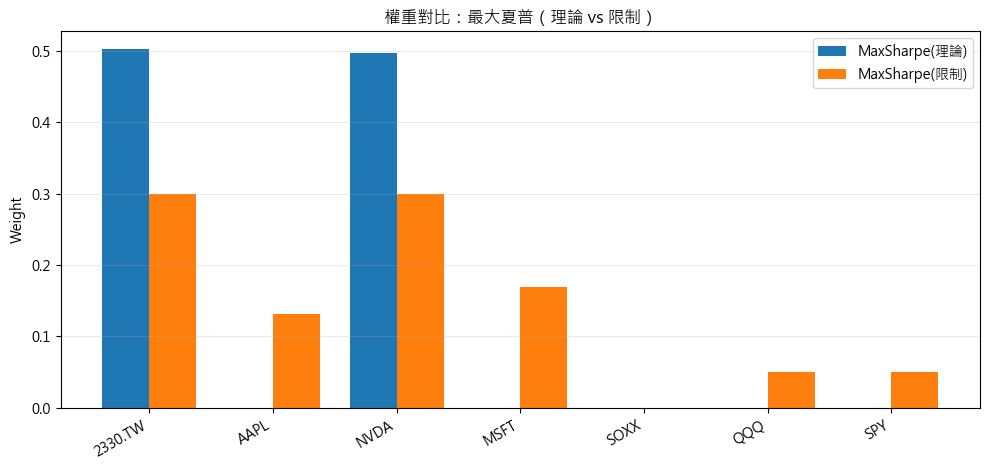

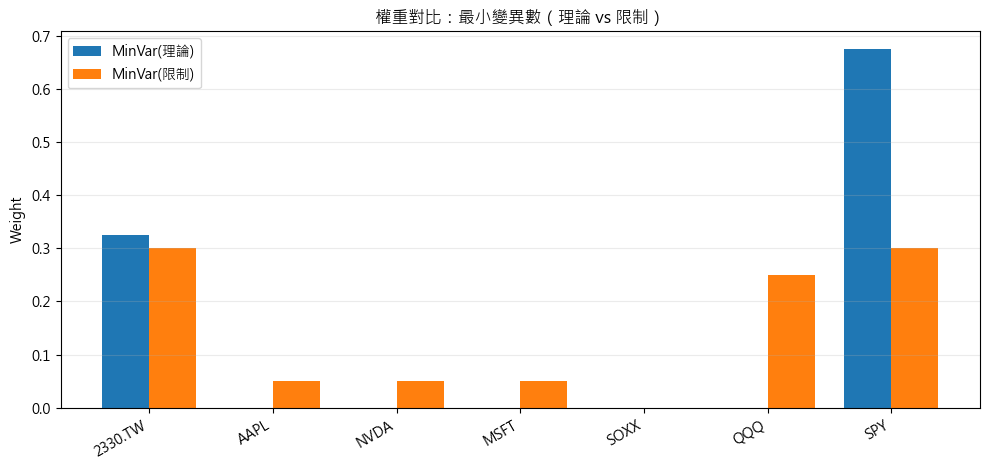


【最大夏普】權重差異（限制-理論）


,MaxSharpe(理論),MaxSharpe(限制),Δ(限制-理論)
MSFT,0.0000,0.1691,0.1691
AAPL,0.0000,0.1309,0.1309
QQQ,0.0000,0.0500,0.0500
SPY,0.0000,0.0500,0.0500
SOXX,0.0000,0.0000,-0.0000
NVDA,0.4976,0.3000,-0.1976
2330.TW,0.5024,0.3000,-0.2024



【最小變異數】權重差異（限制-理論）


,MinVar(理論),MinVar(限制),Δ(限制-理論)
QQQ,0.0000,0.25,0.2500
MSFT,0.0000,0.05,0.0500
AAPL,0.0000,0.05,0.0500
NVDA,0.0000,0.05,0.0500
SOXX,0.0000,0.00,-0.0000
2330.TW,0.3253,0.30,-0.0253
SPY,0.6747,0.30,-0.3747


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 或 'Microsoft YaHei', 'SimHei', 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False  # 正常顯示負號

# 1) 舊/新資產清單
stocks_use_old = [s for s in stocks if s not in ["DX-Y.NYB", "^VIX"]]          # 舊：7 檔（含 SOXX）
stocks_use_new = [s for s in stocks if s not in ["DX-Y.NYB", "^VIX", "SOXX"]]  # 新：6 檔（不含 SOXX）

# 2) 先把權重包成 Series（各自對齊自己的資產順序）
w_ms_old_s = pd.Series(w_max_sharpe,     index=stocks_use_old, name="MaxSharpe(理論)")
w_mv_old_s = pd.Series(w_min_var,        index=stocks_use_old, name="MinVar(理論)")
w_ms_new_s = pd.Series(w_max_sharpe_new, index=stocks_use_new, name="MaxSharpe(限制)")
w_mv_new_s = pd.Series(w_min_var_new,    index=stocks_use_new, name="MinVar(限制)")

# 3) 對齊索引到「聯集」，缺的補 0（新權重沒有 SOXX → 自動補 0）
union_idx = pd.Index(sorted(set(stocks_use_old) | set(stocks_use_new), key=stocks_use_old.index))
w_ms_old_u = w_ms_old_s.reindex(union_idx, fill_value=0.0)
w_ms_new_u = w_ms_new_s.reindex(union_idx, fill_value=0.0)
w_mv_old_u = w_mv_old_s.reindex(union_idx, fill_value=0.0)
w_mv_new_u = w_mv_new_s.reindex(union_idx, fill_value=0.0)

# 4) 畫對比圖
def plot_weight_compare(title, w_old_u: pd.Series, w_new_u: pd.Series):
    x = np.arange(len(w_old_u.index))
    width = 0.38
    fig, ax = plt.subplots(figsize=(10, 4.8))
    ax.bar(x - width/2, w_old_u.values, width, label=w_old_u.name)
    ax.bar(x + width/2, w_new_u.values, width, label=w_new_u.name)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(w_old_u.index, rotation=30, ha="right")
    ax.set_ylabel("Weight")
    ax.set_ylim(0, max(0.35, 1.05*max(w_old_u.max(), w_new_u.max())))
    ax.legend()
    ax.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_weight_compare("權重對比：最大夏普（理論 vs 限制）", w_ms_old_u, w_ms_new_u)
plot_weight_compare("權重對比：最小變異數（理論 vs 限制）", w_mv_old_u, w_mv_new_u)

# 5) 差異表（限制 - 理論），方便檢視哪些資產被降/升權重
diff_ms = pd.concat([w_ms_old_u, w_ms_new_u], axis=1)
diff_ms["Δ(限制-理論)"] = diff_ms.iloc[:,1] - diff_ms.iloc[:,0]
print("\n【最大夏普】權重差異（限制-理論）")
display(diff_ms.sort_values("Δ(限制-理論)", ascending=False).round(4))

diff_mv = pd.concat([w_mv_old_u, w_mv_new_u], axis=1)
diff_mv["Δ(限制-理論)"] = diff_mv.iloc[:,1] - diff_mv.iloc[:,0]
print("\n【最小變異數】權重差異（限制-理論）")
display(diff_mv.sort_values("Δ(限制-理論)", ascending=False).round(4))




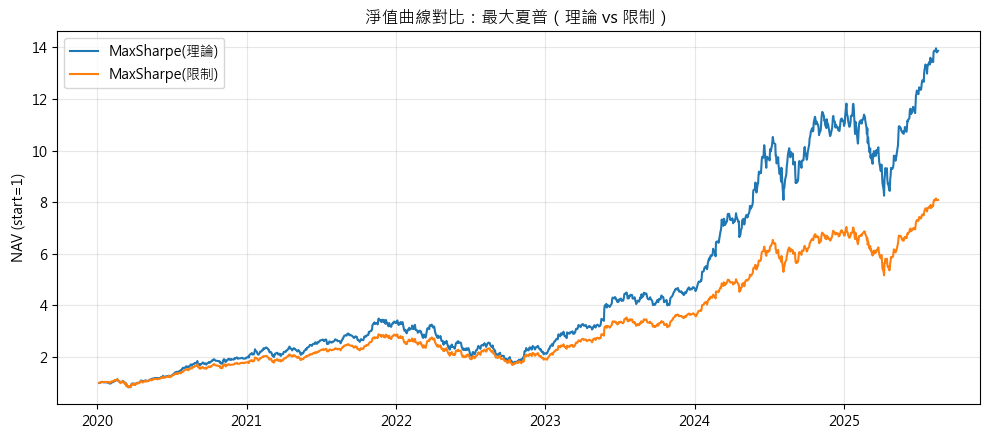

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,4.5))
ax.plot(nav.index, nav.values, label="MaxSharpe(理論)")
ax.plot(nav_new.index, nav_new.values, label="MaxSharpe(限制)")
ax.set_title("淨值曲線對比：最大夏普（理論 vs 限制）"); ax.set_ylabel("NAV (start=1)")
ax.grid(alpha=0.3); ax.legend(); plt.tight_layout(); plt.show()


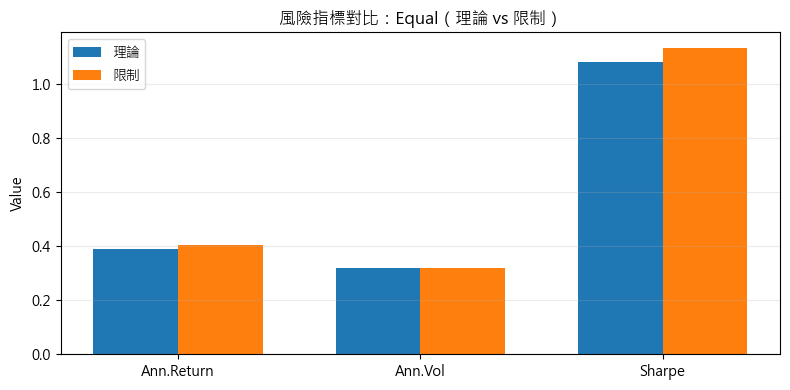

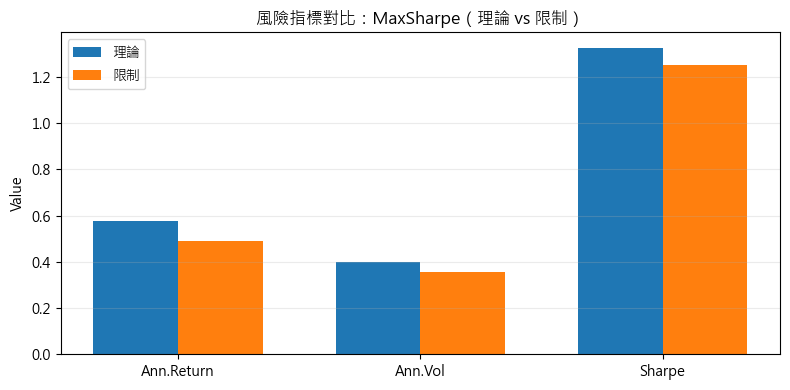

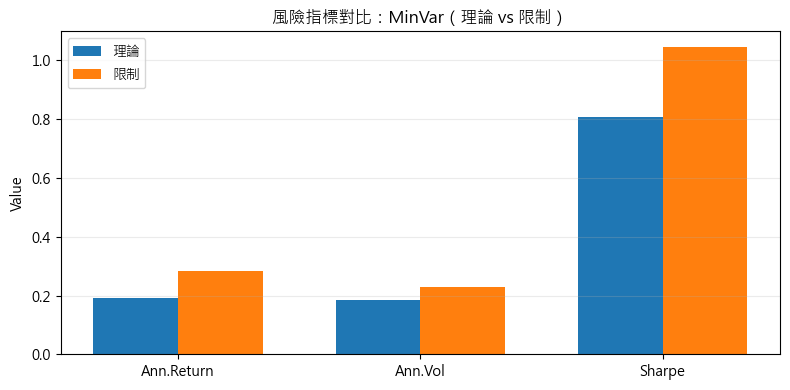

In [71]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 確保 summary、summary_new 兩個表的欄位都是 ["Ann.Return","Ann.Vol","Sharpe"]（若你也算了 MaxDD/VaR/CVaR，可一併加入）
summary_all = pd.concat(
    {"理論": summary, "限制": summary_new}, axis=0
)  # MultiIndex: (版本, 組合)

metrics = ["Ann.Return","Ann.Vol","Sharpe"]
combos  = summary.index.tolist()  # ["Equal","MaxSharpe","MinVar"]

for c in combos:
    df = summary_all.xs(c, level=1)  # 取該組合：理論 vs 限制
    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(metrics)); width = 0.35
    ax.bar(x - width/2, df.loc["理論", metrics].values, width, label="理論")
    ax.bar(x + width/2, df.loc["限制", metrics].values, width, label="限制")
    ax.set_title(f"風險指標對比：{c}（理論 vs 限制）")
    ax.set_xticks(x); ax.set_xticklabels(metrics)
    ax.set_ylabel("Value"); ax.legend(); ax.grid(axis="y", alpha=0.25)
    plt.tight_layout(); plt.show()


【限制版：最近一天】
AnnVol=0.250, MaxDD=0.266, CVaR95=-0.036 | VOL=False, MDD=False, CVaR=False, ANY=False
限制版觸發天數： 53
距離上次觸發的天數： 971


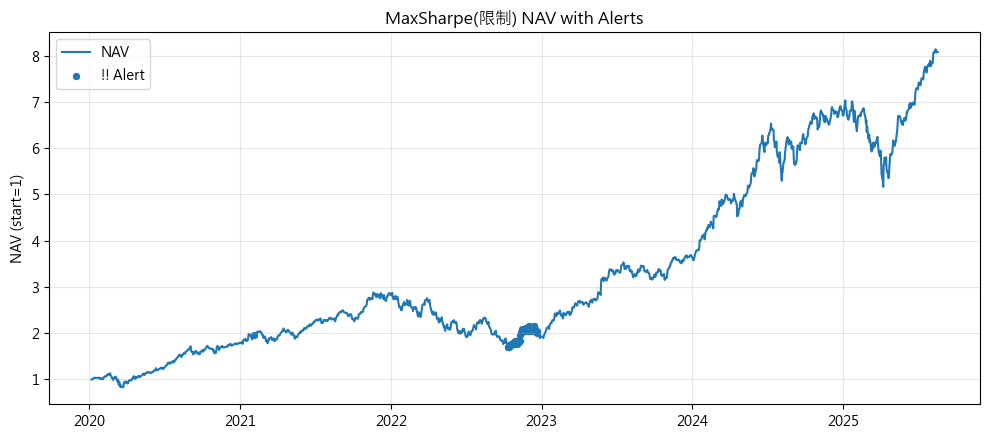

In [72]:
window = 252
VOL_THRESH  = 0.35
MDD_THRESH  = 0.40
CVAR_THRESH = -0.06

#1.滾動年化波動率
annvol_new = Rp_new.rolling(window).std(ddof=1) * sqrt(252)

#2.滾動最大回撤
roll_nav_new = nav_new.rolling(window)
rolling_maxdd_new = roll_nav_new.apply(
    lambda x: ((pd.Series(x).cummax() - pd.Series(x)) / pd.Series(x).cummax()).max(),
    raw=False
)

#3.滾動 VaR / CVaR
var95_new  = Rp_new.rolling(window).quantile(0.05)
cvar95_new = Rp_new.rolling(window).apply(
    lambda x: pd.Series(x)[pd.Series(x) < pd.Series(x).quantile(0.05)].mean(),
    raw=False
)

#4.觸發條件
alert_vol_new  = annvol_new  > VOL_THRESH
alert_mdd_new  = rolling_maxdd_new > MDD_THRESH
alert_cvar_new = cvar95_new  < CVAR_THRESH
alert_any_new  = (pd.concat([alert_vol_new, alert_mdd_new, alert_cvar_new], axis=1)
                    .any(axis=1)
                    .rename("ALERT_ANY"))

#5.最近一天數值 & 是否觸發
last_idx_new = alert_any_new.dropna().index[-1]
print("【限制版：最近一天】")
print(f"AnnVol={annvol_new.loc[last_idx_new]:.3f}, MaxDD={rolling_maxdd_new.loc[last_idx_new]:.3f}, CVaR95={cvar95_new.loc[last_idx_new]:.3f} | "
      f"VOL={bool(alert_vol_new.loc[last_idx_new])}, MDD={bool(alert_mdd_new.loc[last_idx_new])}, CVaR={bool(alert_cvar_new.loc[last_idx_new])}, ANY={bool(alert_any_new.loc[last_idx_new])}")

#6.全期間觸發天數 & 日期
alert_days_new = alert_any_new[alert_any_new].index
print("限制版觸發天數：", alert_days_new.size)

#7.距離上次觸發天數
last_alert_day = alert_days_new.max()
days_since_last_alert = (alert_any_new.index[-1] - last_alert_day).days
print("距離上次觸發的天數：", days_since_last_alert)

#8.視覺化
plt.figure(figsize=(10,4.5))
plt.plot(nav_new.index, nav_new.values, label="NAV")
plt.scatter(alert_days_new, nav_new.loc[alert_days_new], s=18, marker="o", label="!! Alert")
plt.title("MaxSharpe(限制) NAV with Alerts")
plt.ylabel("NAV (start=1)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

In [73]:
tc = 0.0          # 單邊交易成本（例：0.001 = 0.1%），先設 0 看機制
window = 252      # 之後做風險監測可以沿用
rf = 0.043


# 1) 再平衡日
idx_new = R_new.index
rebal_dates_new = R_new.resample("YE").last().index

# 2) 初始化
w_target_new = pd.Series(w_max_sharpe_new, index=R_new.columns)
nav_list_new = [1.0]
holding_value_new = (w_target_new.values * nav_list_new[0]).astype(float)

# 3) 逐日模擬
for t in range(1, len(idx_new)):
    r_t = R_new.iloc[t].values
    holding_value_new *= (1 + r_t)
    nav_t = holding_value_new.sum()

    if idx_new[t] in rebal_dates_new:
        target_value = nav_t * w_target_new.values
        trade_amount = np.abs(target_value - holding_value_new).sum()
        cost = tc * trade_amount
        nav_t = nav_t - cost
        holding_value_new = (nav_t * w_target_new.values)

    nav_list_new.append(nav_t)

nav_yr_new = pd.Series(nav_list_new, index=idx_new, name="NAV_yearly_rebal_new")
ret_yr_new = nav_yr_new.pct_change().fillna(0.0).rename("ret_yearly_new")

# 參考用的 Buy & Hold（限制版）
wealth_new = (1 + R_new).cumprod()
nav_bh_new = wealth_new.mul(w_target_new.values, axis=1).sum(axis=1)
nav_bh_new = nav_bh_new / nav_bh_new.iloc[0]
ret_bh_new = nav_bh_new.pct_change().fillna(0.0).rename("ret_bh_new")


In [74]:
def _stats(r):
    ann_mu  = r.mean() * 252
    ann_vol = r.std(ddof=1) * sqrt(252)
    sharpe  = (ann_mu - rf) / ann_vol if ann_vol > 0 else np.nan
    return ann_mu, ann_vol, sharpe

res = pd.DataFrame(
    [_stats(ret_bh_new), _stats(ret_yr_new)],
    index=["Buy&Hold", "YearlyRebal"],
    columns=["Ann.Return","Ann.Vol","Sharpe"]
).round(4)
print(res)


             Ann.Return  Ann.Vol  Sharpe
Buy&Hold         0.4891   0.3569  1.2498
YearlyRebal      0.4877   0.3556  1.2507


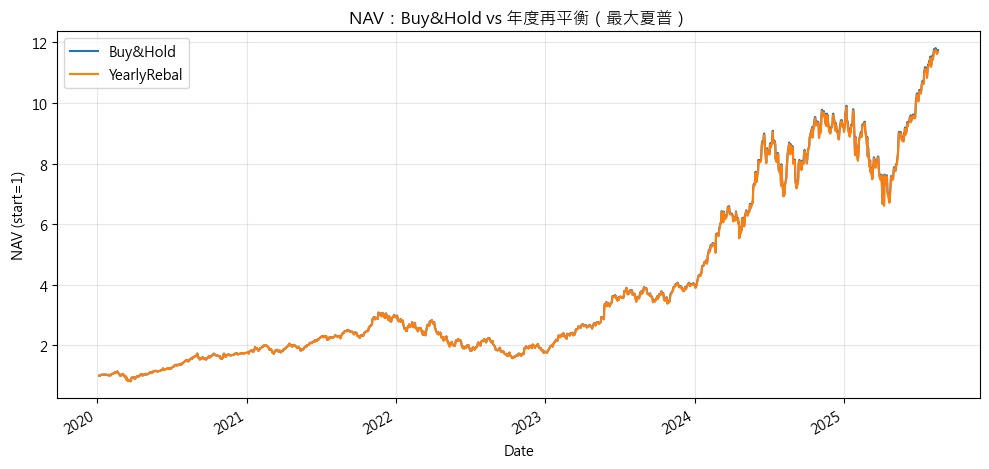

In [75]:
ax = pd.concat([nav_bh_new.rename("Buy&Hold"), nav_yr_new.rename("YearlyRebal")], axis=1) \
       .plot(figsize=(10,4.8), title="NAV：Buy&Hold vs 年度再平衡（最大夏普）")
ax.set_ylabel("NAV (start=1)")
ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()


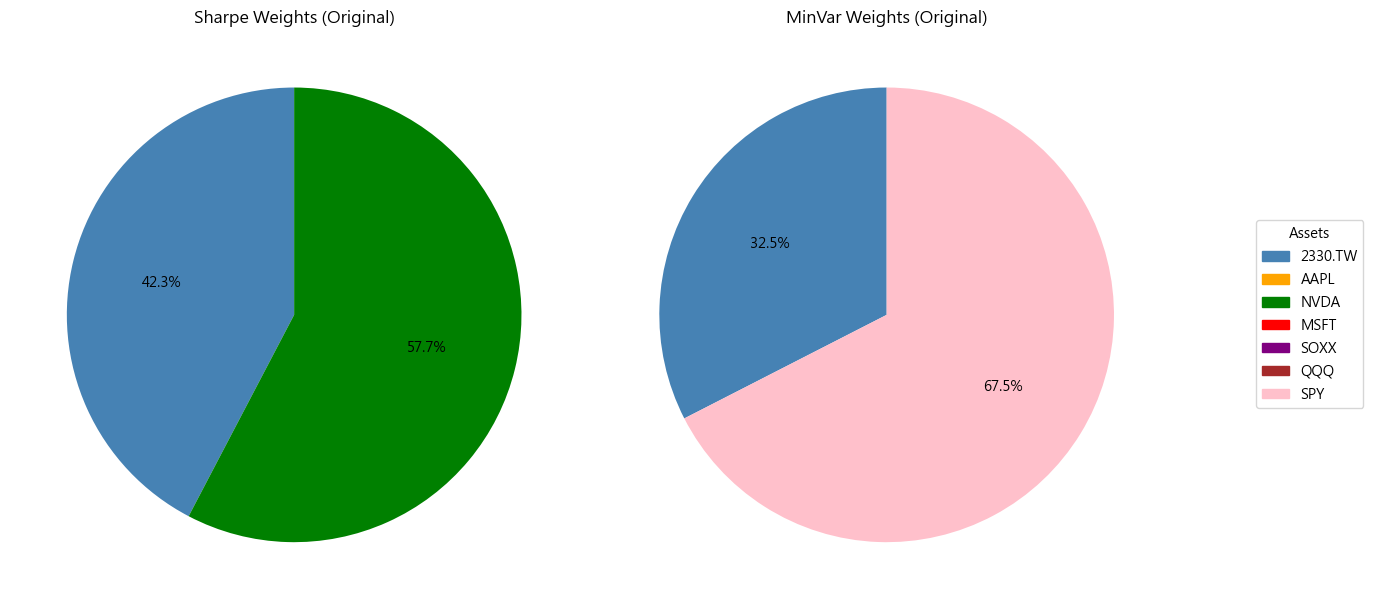

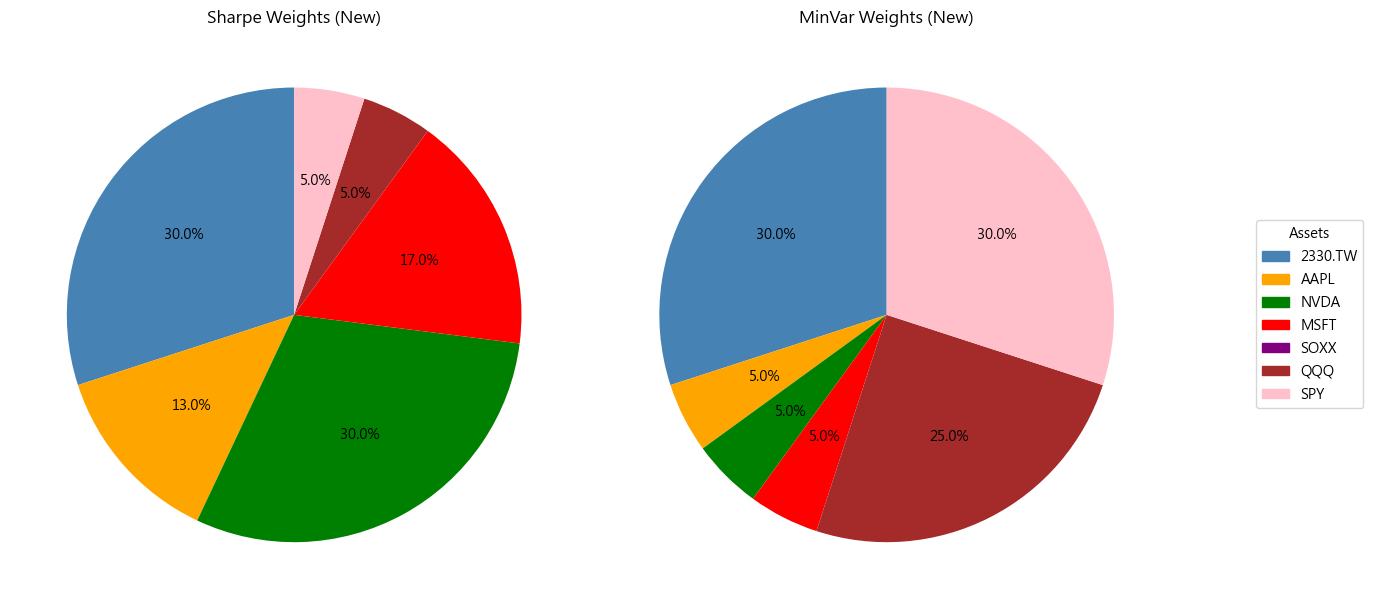

In [76]:
sharpes_wieght_forpie=[0.4232, 0.0000, 0.5768, 0.0000, 0.0000, 0.0000, 0.0000]
labels_forpie=['2330.TW','AAPL','NVDA','MSFT','SOXX','QQQ','SPY']
minvar_weight_forpie=[0.3253, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6747]

sharpes_wieght_new_forpie=[0.3000, 0.1299, 0.3000, 0.1701, 0.0500, 0.0500]
minvar_weight_new_forpie=[0.3000, 0.0500, 0.0500, 0.0500, 0.2500, 0.3000]
labels_new_forpie=['2330.TW','AAPL','NVDA','MSFT','QQQ','SPY']


color_map = {
    '2330.TW': 'steelblue',
    'AAPL': 'orange',
    'NVDA': 'green',
    'MSFT': 'red',
    'SOXX': 'purple',
    'QQQ': 'brown',
    'SPY': 'pink'
}
def plot_pie(ax, weights, labels, title):
    # 過濾掉 0 權重
    weights_filtered = [w for w,l in zip(weights, labels) if w > 0]
    labels_filtered = [l for w,l in zip(weights, labels) if w > 0]
    colors = [color_map[l] for l in labels_filtered]
    
    ax.pie(weights_filtered, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title(title)

# ========== 畫布 1: Original ==========
fig1, axes1 = plt.subplots(1, 2, figsize=(12, 6))

plot_pie(axes1[0], sharpes_wieght_forpie, labels_forpie, "Sharpe Weights (Original)")
plot_pie(axes1[1], minvar_weight_forpie, labels_forpie, "MinVar Weights (Original)")

# 共用 legend
handles = [plt.matplotlib.patches.Patch(color=color_map[l], label=l) for l in color_map]
fig1.legend(handles=handles, loc='center right', bbox_to_anchor=(1.15, 0.5), title="Assets")

plt.tight_layout()
plt.show()

# ========== 畫布 2: New ==========
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 6))

plot_pie(axes2[0], sharpes_wieght_new_forpie, labels_new_forpie, "Sharpe Weights (New)")
plot_pie(axes2[1], minvar_weight_new_forpie, labels_new_forpie, "MinVar Weights (New)")

# 共用 legend
fig2.legend(handles=handles, loc='center right', bbox_to_anchor=(1.15, 0.5), title="Assets")

plt.tight_layout()
plt.show()


In [77]:
Rp_var=R @ w_min_var
nav_var = (1 + Rp_var).cumprod()
rolling_max_var = nav_var.cummax()
drawdown_var = (rolling_max_var - nav_var) / rolling_max_var
max_drawdown_var = drawdown_var.max()

var_95_var = np.percentile(Rp_var, 5)
cvar_95_var = Rp_var[Rp_var < var_95_var].mean()

print("Max Drawdown:\n", max_drawdown_var)
print('\nvar_95:\n',var_95_var)
print('\ncvar_95:\n',cvar_95_var)

Max Drawdown:
 0.2984807599081557

var_95:
 -0.016330505848175678

cvar_95:
 -0.025781177599262028


In [78]:
Rp_var_new=R_new @ w_min_var_new
nav_var_new = (1 + Rp_var_new).cumprod()
rolling_max_var_new = nav_var_new.cummax()
drawdown_var_new = (rolling_max_var_new - nav_var_new) / rolling_max_var_new
max_drawdown_var_new = drawdown_var_new.max()

var_95_var_new = np.percentile(Rp_var_new, 5)
cvar_95_var_new = Rp_var_new[Rp_var_new < var_95_var_new].mean()

print("Max Drawdown:\n", max_drawdown_var_new)
print('\nvar_95:\n',var_95_var_new)
print('\ncvar_95:\n',cvar_95_var_new)

Max Drawdown:
 0.324903435768684

var_95:
 -0.019470175996284606

cvar_95:
 -0.028868648040480657


In [79]:
equal_weight = np.ones(len(R.columns)) / len(R.columns)
Rp_eq=R @ equal_weight
nav_eq = (1 + Rp_eq).cumprod()
rolling_max_eq = nav_eq.cummax()
drawdown_eq = (rolling_max_eq - nav_eq) / rolling_max_eq
max_drawdown_eq = drawdown_eq.max()

var_95_eq = np.percentile(Rp_eq, 5)
cvar_95_eq = Rp_eq[Rp_eq < var_95_eq].mean()

print("Max Drawdown:\n", max_drawdown_eq)
print('\nvar_95:\n',var_95_eq)
print('\ncvar_95:\n',cvar_95_eq)


Max Drawdown:
 0.3696203218552744

var_95:
 -0.02465526266491919

cvar_95:
 -0.037271968926665074
